In [52]:
# ==========================================================
# Wavelet分類回復 (FGSM攻撃済みTensor入力)
# ==========================================================
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import pywt
from pathlib import Path
from tqdm import tqdm


# ==========================================================
# === Waveletノイズ除去関数 ===　DWT
# ==========================================================
def wavelet_denoise(img_tensor, wavelet='haar', level=1, threshold=0.07):
    """Tensor画像にWavelet変換を適用し、高周波ノイズを除去"""
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(0)

    img_np = img_tensor.detach().cpu().numpy()
    denoised = []

    for b in range(img_np.shape[0]):
        channels = []
        for c in range(img_np.shape[1]):
            coeffs = pywt.wavedec2(img_np[b, c], wavelet=wavelet, level=level)
            cA, cD = coeffs[0], coeffs[1:]
            cD_thresh = []
            for (cH, cV, cD_) in cD:
                cH = pywt.threshold(cH, threshold * np.max(np.abs(cH)))
                cV = pywt.threshold(cV, threshold * np.max(np.abs(cV)))
                cD_ = pywt.threshold(cD_, threshold * np.max(np.abs(cD_)))
                cD_thresh.append((cH, cV, cD_))
            coeffs_thresh = [cA] + cD_thresh
            denoised_channel = pywt.waverec2(coeffs_thresh, wavelet)
            denoised_channel = denoised_channel[:img_np.shape[2], :img_np.shape[3]]
            channels.append(denoised_channel)
        denoised.append(np.stack(channels))
    denoised = np.stack(denoised)
    return torch.tensor(denoised).to(img_tensor.device).float().clamp(0, 1)


# ==========================================================
# === MobileNetV2分類モデル ===
# ==========================================================
def load_model(device):
    """MobileNetV2をロード"""
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    model = model.to(device).eval()
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    return model, normalize


def predict(model, img_tensor, normalize):
    """モデルで分類し、(クラスID, 信頼度) を返す"""
    with torch.no_grad():
        normed = normalize(img_tensor)
        preds = F.softmax(model(normed), dim=1)
        conf, idx = preds.max(1)
        return int(idx.item()), float(conf.item())


# ==========================================================
# === メイン処理 ===
# ==========================================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- モデルロード ---
    model, normalize = load_model(device)

    # --- パス設定 (あなたの構成に対応) ---
    base_dir = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM")
    tensor_dir = base_dir / "tensor"              # ✅ FGSM攻撃済みTensorフォルダ
    output_root = base_dir / "wavelet_eval"       # 出力ルート
    out_tensor_dir = output_root / "wavelet_tensor"
    out_image_dir = output_root / "wavelet_images"
    os.makedirs(out_tensor_dir, exist_ok=True)
    os.makedirs(out_image_dir, exist_ok=True)

    # --- 結果リスト ---
    results = []

    print(f"\n=== Wavelet分類回復処理 (FGSM入力) 開始 ===")
    print(f"入力フォルダ: {tensor_dir}")
    print(f"出力フォルダ: {output_root}\n")

    # --- ループ処理 ---
    for fname in tqdm(sorted(os.listdir(tensor_dir))):
        if not fname.lower().endswith(".pt"):
            continue
        name = os.path.splitext(fname)[0]
        tensor_path = tensor_dir / fname

        try:
            # --- Tensor読み込み ---
            input_tensor = torch.load(tensor_path, map_location=device)
            if input_tensor.ndim == 3:
                input_tensor = input_tensor.unsqueeze(0)

            # --- Wavelet変換 ---
            wavelet_tensor = wavelet_denoise(input_tensor)
            wavelet_tensor = wavelet_tensor.clamp(0, 1)

            # --- 分類 ---
            label_id, confidence = predict(model, wavelet_tensor, normalize)
            label_name = models.MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"][label_id]

            # --- 保存 ---
            torch.save(wavelet_tensor.cpu(), out_tensor_dir / f"{name}_wavelet.pt")
            save_image(wavelet_tensor.cpu(), out_image_dir / f"{name}_wavelet.png")

            # --- 結果記録 ---
            results.append({
                "ImageId": name,
                "Wavelet_Label": label_name,
                "Wavelet_Confidence": round(confidence, 6)
            })

        except Exception as e:
            print(f"[ERROR] {name}: {e}")

    # --- CSV出力 ---
    csv_path = output_root / "FGSM_Wavelet_class_results.csv"
    pd.DataFrame(results).to_csv(csv_path, index=False, encoding="utf-8-sig")

    print("\n=== FGSM攻撃済みTensor → Wavelet分類回復処理 完了 ===")
    print(f"出力CSV: {csv_path}")



=== Wavelet分類回復処理 (FGSM入力) 開始 ===
入力フォルダ: C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\tensor
出力フォルダ: C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval



100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]


=== FGSM攻撃済みTensor → Wavelet分類回復処理 完了 ===
出力CSV: C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval\FGSM_Wavelet_class_results.csv


In [53]:
# ==========================================================
# 攻撃前＋攻撃後＋Wavelet分類結果の統合＆成功判定（絶対パス・列名対応完全版）
# ==========================================================
import pandas as pd
from pathlib import Path

print("=== 3段階CSV統合を開始 ===\n")

# ==========================================================
# === 各CSVの絶対パスを明示 ===
# ==========================================================
# 攻撃前（正しい分類結果）
before_csv = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\data3\clean_dataset_labels.csv")

# 攻撃後（FGSM攻撃結果）
after_csv = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\FGSM_Results.csv")

# Wavelet分類回復後
wavelet_csv = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval\FGSM_Wavelet_class_results.csv")

# 出力先（統合結果）
output_csv = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval\FGSM_All_Compare.csv")

# 矯正成功のみ抽出出力
success_csv = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval\FGSM_RecoverySuccessOnly.csv")

# ==========================================================
# === CSV読み込み ===
# ==========================================================
print(f"攻撃前: {before_csv}")
print(f"攻撃後: {after_csv}")
print(f"分類回復後(Wavelet): {wavelet_csv}\n")

df_before = pd.read_csv(before_csv)
df_after = pd.read_csv(after_csv)
df_wave = pd.read_csv(wavelet_csv)

# ==========================================================
# === 列確認 ===
# ==========================================================
print("攻撃前 CSV列:", list(df_before.columns))
print("攻撃後 CSV列:", list(df_after.columns))
print("Wavelet CSV列:", list(df_wave.columns))
print()

# ==========================================================
# === ImageId整形 ===
# ==========================================================
df_before["ImageId"] = df_before["image"].apply(lambda x: Path(str(x)).stem)
df_after["ImageId"] = df_after["image"].apply(lambda x: Path(str(x)).stem)

# ==========================================================
# === 列名を統一して扱いやすくする ===
# ==========================================================
df_before = df_before.rename(columns={
    "label_name": "label_name_before",
    "confidence": "confidence_before"
})

df_after = df_after.rename(columns={
    "Advs_label_name": "label_name_after",
    "Advs_confidence": "confidence_after"
})

# ==========================================================
# === 結合処理 ===
# ==========================================================
df_merged = df_before.merge(df_after, on="ImageId", suffixes=("_before", "_after"))
df_merged = df_merged.merge(df_wave, on="ImageId", how="left")

# ==========================================================
# === 攻撃成功・矯正成功 判定 ===
# ==========================================================
df_merged["AttackSuccess"] = df_merged.apply(
    lambda x: x["label_name_before"] != x["label_name_after"], axis=1
)
df_merged["RecoverySuccess"] = df_merged.apply(
    lambda x: x["label_name_before"] == x["Wavelet_Label"], axis=1
)

# ==========================================================
# === 出力整形 ===
# ==========================================================
cols_order = [
    "ImageId",
    "label_name_before", "confidence_before",
    "label_name_after", "confidence_after",
    "Wavelet_Label", "Wavelet_Confidence",
    "AttackSuccess", "RecoverySuccess"
]

df_final = df_merged[cols_order]

# ==========================================================
# === 結果出力 ===
# ==========================================================
df_final.to_csv(output_csv, index=False, encoding="utf-8-sig")
print(f"✅ 統合完了: {output_csv}")

# ==========================================================
# === 統計 ===
# ==========================================================
total = len(df_final)
attack_success = df_final["AttackSuccess"].sum()
recovery_success = df_final["RecoverySuccess"].sum()

attack_rate = (attack_success / total) * 100 if total > 0 else 0
recovery_rate = (recovery_success / total) * 100 if total > 0 else 0

print("\n=== 統計結果 ===")
print(f"攻撃成功数: {attack_success}/{total} ({attack_rate:.2f}%)")
print(f"矯正成功数: {recovery_success}/{total} ({recovery_rate:.2f}%)")

# ==========================================================
# === 矯正成功のみ抽出 ===
# ==========================================================
df_success = df_final[df_final["RecoverySuccess"] == True]
df_success.to_csv(success_csv, index=False, encoding="utf-8-sig")

print(f"\n✅ 矯正成功画像のみ抽出: {success_csv}")

print("\n=== 全処理完了 ===")
print(f"成功画像リストCSV: {success_csv}")


=== 3段階CSV統合を開始 ===

攻撃前: C:\Users\sit\wavelet_CGAN\testdata3\data3\clean_dataset_labels.csv
攻撃後: C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\FGSM_Results.csv
分類回復後(Wavelet): C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval\FGSM_Wavelet_class_results.csv

攻撃前 CSV列: ['image', 'label_id', 'label_name', 'confidence']
攻撃後 CSV列: ['image', 'Original_label', 'Original_label_name', 'Original_confidence', 'Advs_label', 'Advs_label_name', 'Advs_confidence', 'Advs_eps', 'Tensor_path']
Wavelet CSV列: ['ImageId', 'Wavelet_Label', 'Wavelet_Confidence']

✅ 統合完了: C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval\FGSM_All_Compare.csv

=== 統計結果 ===
攻撃成功数: 1000/1000 (100.00%)
矯正成功数: 856/1000 (85.60%)

✅ 矯正成功画像のみ抽出: C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval\FGSM_RecoverySuccessOnly.csv

=== 全処理完了 ===
成功画像リストCSV: C:\Users\sit\wavelet_CGAN\testdata3\data3_FGSM\wavelet_eval\FGSM_RecoverySuccessOnly.csv


In [1]:
# ==========================================================
# 攻撃前・攻撃後・Wavelet変換後の分類結果をWord表に出力（先頭100枚）
# ==========================================================
import pandas as pd
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from pathlib import Path

# === 入力CSV（統合済み）===
input_csv = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\pix2pix_restore_FGSM_train\data2_FGSM\compare_data2_FGSM_Wavelet_CGAN.csv")

# === 出力Wordファイル ===
output_docx = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\data1_FGSM\wavelet_eval\FGSM_3Stage_Top100.docx")

# === CSV読み込み ===
df = pd.read_csv(input_csv)

# === 先頭100枚を抽出 ===
df_show = df.head(100).copy()

# === 表に使用する列を選択 ===
columns = [
    "label_name_before", "confidence_before",
    "label_name_after", "confidence_after",
    "Wavelet_Label", "Wavelet_Confidence"
]
df_show = df_show[columns].copy()

# === 列名を日本語化 ===
df_show.columns = [
    "入力画像ラベル（攻撃前）", "信頼度（攻撃前）",
    "敵対的画像ラベル（攻撃後）", "信頼度（攻撃後）",
    "Wavelet変換後ラベル", "信頼度（Wavelet後）"
]

# === Word文書作成 ===
doc = Document()
doc.add_heading("攻撃前・攻撃後・Wavelet変換後の分類結果（先頭100枚）", level=1)

# === 表作成 ===
table = doc.add_table(rows=1, cols=len(df_show.columns))
table.style = "Table Grid"

# --- ヘッダー行 ---
hdr_cells = table.rows[0].cells
for i, col_name in enumerate(df_show.columns):
    hdr_cells[i].text = col_name

# --- データ行 ---
for _, row in df_show.iterrows():
    row_cells = table.add_row().cells
    for i, value in enumerate(row):
        # 小数は6桁に丸める
        if isinstance(value, float):
            value = round(value, 6)
        row_cells[i].text = str(value)

# === 書式設定（中央揃え＋フォント10pt）===
for row in table.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
            for run in paragraph.runs:
                run.font.size = Pt(10)

# === 保存 ===
doc.save(output_docx)

print("✅ Word出力完了")
print(f"出力先: {output_docx}")


✅ Word出力完了
出力先: C:\Users\sit\wavelet_CGAN\testdata3\data1_FGSM\wavelet_eval\FGSM_3Stage_Top100.docx


In [5]:
# ==========================================================
# Wavelet分類回復 (未攻撃Tensor入力)
# ==========================================================
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import pywt
from pathlib import Path
from tqdm import tqdm


# ==========================================================
# === Waveletノイズ除去関数 ===　DWT
# ==========================================================
def wavelet_denoise(img_tensor, wavelet='haar', level=1, threshold=0.07):
    """Tensor画像にWavelet変換を適用し、高周波ノイズを除去"""
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(0)

    img_np = img_tensor.detach().cpu().numpy()
    denoised = []

    for b in range(img_np.shape[0]):
        channels = []
        for c in range(img_np.shape[1]):
            coeffs = pywt.wavedec2(img_np[b, c], wavelet=wavelet, level=level)
            cA, cD = coeffs[0], coeffs[1:]
            cD_thresh = []
            for (cH, cV, cD_) in cD:
                cH = pywt.threshold(cH, threshold * np.max(np.abs(cH)))
                cV = pywt.threshold(cV, threshold * np.max(np.abs(cV)))
                cD_ = pywt.threshold(cD_, threshold * np.max(np.abs(cD_)))
                cD_thresh.append((cH, cV, cD_))
            coeffs_thresh = [cA] + cD_thresh
            denoised_channel = pywt.waverec2(coeffs_thresh, wavelet)
            denoised_channel = denoised_channel[:img_np.shape[2], :img_np.shape[3]]
            channels.append(denoised_channel)
        denoised.append(np.stack(channels))
    denoised = np.stack(denoised)
    return torch.tensor(denoised).to(img_tensor.device).float().clamp(0, 1)


# ==========================================================
# === MobileNetV2分類モデル ===
# ==========================================================
def load_model(device):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    model = model.to(device).eval()
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    return model, normalize


def predict(model, img_tensor, normalize):
    with torch.no_grad():
        normed = normalize(img_tensor)
        preds = F.softmax(model(normed), dim=1)
        conf, idx = preds.max(1)
        return int(idx.item()), float(conf.item())


# ==========================================================
# === メイン処理 ===
# ==========================================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, normalize = load_model(device)

    # --- フォルダ構成を整理 ---
    base_dir = Path(r"C:\Users\sit\wavelet_CGAN\testdata3")
    tensor_dir = base_dir / "data3_clean_tensor"     # 入力: 未攻撃Tensor
    eval_root = base_dir / "data3_clean_eval"        # ✅ 新しいサブフォルダを作成
    output_root = eval_root / "wavelet_eval"         # 出力ルート
    out_tensor_dir = output_root / "wavelet_tensor"
    out_image_dir = output_root / "wavelet_images"
    os.makedirs(out_tensor_dir, exist_ok=True)
    os.makedirs(out_image_dir, exist_ok=True)

    # --- 結果リスト ---
    results = []

    print(f"\n=== Wavelet分類回復処理 (未攻撃Tensor) 開始 ===")
    print(f"入力フォルダ: {tensor_dir}")
    print(f"出力フォルダ: {output_root}\n")

    # --- ループ処理 ---
    for fname in tqdm(sorted(os.listdir(tensor_dir))):
        if not fname.lower().endswith(".pt"):
            continue
        name = os.path.splitext(fname)[0]
        tensor_path = tensor_dir / fname

        try:
            input_tensor = torch.load(tensor_path, map_location=device)
            if input_tensor.ndim == 3:
                input_tensor = input_tensor.unsqueeze(0)

            wavelet_tensor = wavelet_denoise(input_tensor)
            wavelet_tensor = wavelet_tensor.clamp(0, 1)

            label_id, confidence = predict(model, wavelet_tensor, normalize)
            label_name = models.MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"][label_id]

            torch.save(wavelet_tensor.cpu(), out_tensor_dir / f"{name}_wavelet.pt")
            save_image(wavelet_tensor.cpu(), out_image_dir / f"{name}_wavelet.png")

            results.append({
                "ImageId": name,
                "Wavelet_Label": label_name,
                "Wavelet_Confidence": round(confidence, 6)
            })

        except Exception as e:
            print(f"[ERROR] {name}: {e}")

    # --- CSV出力 ---
    csv_path = output_root / "clean_Wavelet_class_results.csv"  # ✅ 名前も変更
    pd.DataFrame(results).to_csv(csv_path, index=False, encoding="utf-8-sig")

    print("\n=== 未攻撃Tensor → Wavelet分類回復処理 完了 ===")
    print(f"出力CSV: {csv_path}")



=== Wavelet分類回復処理 (未攻撃Tensor) 開始 ===
入力フォルダ: C:\Users\sit\wavelet_CGAN\testdata3\data3_clean_tensor
出力フォルダ: C:\Users\sit\wavelet_CGAN\testdata3\data3_clean_eval\wavelet_eval



100%|██████████| 1000/1000 [00:33<00:00, 29.92it/s]


=== 未攻撃Tensor → Wavelet分類回復処理 完了 ===
出力CSV: C:\Users\sit\wavelet_CGAN\testdata3\data3_clean_eval\wavelet_eval\clean_Wavelet_class_results.csv


In [13]:
# ==========================================================
# Wavelet＋CGAN復元＋通常画像評価（実験4-2-2-3対応）
# ==========================================================
import os
import sys
import torch
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
from torchvision import models
from torchvision.utils import save_image
from torch import nn
from tqdm import tqdm
from shutil import copy2

# ========= 0) 再現性（任意） =========
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ========= 1) 設定 =========
dataset     = "data1"         # cleanデータセット名
attack_type = "clean"         # ✅ 未攻撃画像モード
LEGACY_PREPROCESS = True

BASE = Path(r"C:\Users\sit\wavelet_CGAN\testdata3")

# ========= 入出力パス =========
clean_dir     = BASE / dataset
wavelet_dir   = BASE / f"{dataset}_clean_eval" / "wavelet_eval"
tensor_dir    = wavelet_dir / "wavelet_tensor"
wavelet_png_dir = wavelet_dir / "wavelet_images"

# CGAN出力フォルダ
cgan_out_dir = BASE / "pix2pix_restore_clean" / dataset
cgan_out_dir.mkdir(parents=True, exist_ok=True)

# CSV出力先（すべて画像と同じフォルダ）
cgan_csv   = cgan_out_dir / f"pix2pix_class_results_{dataset}_{attack_type}.csv"
merged_csv = cgan_out_dir / f"compare_{dataset}_{attack_type}_Wavelet_CGAN.csv"
failed_list_csv = cgan_out_dir / f"failed_lists_{dataset}_{attack_type}.csv"

# 入力CSV
before_csv   = clean_dir / "clean_dataset_labels.csv"
wavelet_csv  = wavelet_dir / "clean_Wavelet_class_results.csv"

# 失敗画像の保存先
wavelet_failed_dir = BASE / "wavelet_restore_failed" / f"{dataset}_{attack_type}"
cgan_failed_dir    = BASE / "cgan_restore_failed"    / f"{dataset}_{attack_type}"
wavelet_failed_dir.mkdir(parents=True, exist_ok=True)
cgan_failed_dir.mkdir(parents=True, exist_ok=True)

# CGAN Generator重み
weight_path  = BASE / "pix2pix_train_v2" / "weights" / "gen_weights_epoch300.pth"


# ========= 2) 事前チェック =========
def _must_exist(p: Path, hint: str = ""):
    if not p.exists():
        print(f"[ERROR] Not found: {p}")
        if hint:
            print("Hint:", hint)
        sys.exit(1)

_must_exist(before_csv,  "clean_dataset_labels.csv を作成してください。")
_must_exist(wavelet_csv, f"clean_Wavelet_class_results.csv を作成してください。")
_must_exist(tensor_dir,  "wavelet_eval/wavelet_tensor に *_wavelet.pt を出力してください。")
_must_exist(weight_path, "pix2pix 学習済み重みのパスを確認してください。")


# ========= 3) MobileNetV2分類モデル =========
def load_classifier(device):
    weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
    model = models.mobilenet_v2(weights=weights).to(device).eval()
    categories = weights.meta["categories"]
    preprocess = weights.transforms() if LEGACY_PREPROCESS else T.Normalize(mean=weights.meta["mean"], std=weights.meta["std"])
    return model, preprocess, categories


# ========= 4) CGAN Generator =========
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        self.encoder = nn.Sequential(
            self.block(in_channels, features, normalize=False),
            self.block(features, features * 2),
            self.block(features * 2, features * 4),
            self.block(features * 4, features * 8),
            self.block(features * 8, features * 8),
        )
        self.decoder = nn.Sequential(
            self.upblock(features * 8, features * 8),
            self.upblock(features * 8 * 2, features * 4),
            self.upblock(features * 4 * 2, features * 2),
            self.upblock(features * 2 * 2, features),
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def block(self, in_c, out_c, normalize=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def upblock(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x); skips.append(x)
        skips = skips[:-1][::-1]
        for i, layer in enumerate(self.decoder[:-2]):
            x = layer(x)
            if i < len(skips):
                x = torch.cat([x, skips[i]], 1)
        return self.decoder[-2](x)


# ========= 5) CGAN復元＋分類 =========
def restore_and_classify():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gen = UNetGenerator().to(device)
    gen.load_state_dict(torch.load(weight_path, map_location=device))
    gen.eval()

    clf, preprocess, categories = load_classifier(device)
    results = []

    print(f"\n=== CGAN推論＋分類開始 ({dataset}/{attack_type}) ===\n")

    with torch.no_grad():
        for fname in tqdm(sorted(os.listdir(tensor_dir))):
            if not fname.endswith(".pt"):
                continue
            t = torch.load(tensor_dir / fname, map_location=device)
            if t.ndim == 3:
                t = t.unsqueeze(0)

            t_in = (t - 0.5) / 0.5 if (t.min() >= 0 and t.max() <= 1) else t
            restored = gen(t_in.to(device))
            restored_01 = (restored * 0.5 + 0.5).clamp(0, 1)

            x = restored_01.squeeze(0).cpu()
            x = preprocess(x).unsqueeze(0).to(device)
            preds = F.softmax(clf(x), dim=1)
            conf, idx = preds.max(1)
            label = categories[int(idx)]
            confidence = float(conf.item())

            base = Path(fname).stem.replace("_wavelet", "")
            out_png = cgan_out_dir / f"{base}_{attack_type}_restored.png"
            save_image(restored_01.cpu(), out_png)

            results.append({
                "ImageId": base,
                "CGAN_Label": label,
                "CGAN_Confidence": round(confidence, 6),
            })

    pd.DataFrame(results).to_csv(cgan_csv, index=False, encoding="utf-8-sig")
    print(f"✅ CGAN分類結果CSV: {cgan_csv}")
    print(f"✅ 復元画像: {cgan_out_dir}")


# ========= 6) 統合評価（未攻撃用） =========
def merge_and_evaluate():
    print(f"\n=== 通常画像に対するWavelet＋CGAN評価 ({dataset}/{attack_type}) ===\n")

    df_b  = pd.read_csv(before_csv)
    df_w  = pd.read_csv(wavelet_csv)
    df_g  = pd.read_csv(cgan_csv)

    df_b["ImageId"] = df_b["image"].apply(lambda x: Path(str(x)).stem)
    df_g["ImageId"] = df_g["ImageId"].astype(str).apply(
        lambda s: Path(s).stem.replace(f"_{attack_type}_restored", "").replace("_wavelet", "")
    )

    df_b = df_b.rename(columns={"label_name": "label_name_before", "confidence": "confidence_before"})

    df = (df_b.merge(df_w, on="ImageId", how="left")
              .merge(df_g, on="ImageId", how="left"))

    df["RecoverySuccess_Wavelet"] = df["label_name_before"] == df.get("Wavelet_Label")
    df["RecoverySuccess_CGAN"]    = df["label_name_before"] == df.get("CGAN_Label")

    df.to_csv(merged_csv, index=False, encoding="utf-8-sig")

    total = len(df)
    w_ok  = int(df["RecoverySuccess_Wavelet"].sum())
    g_ok  = int(df["RecoverySuccess_CGAN"].sum())
    pct   = lambda n: (n / total * 100.0) if total else 0.0

    print("=== 統計結果 ===")
    print(f"総数: {total}")
    print(f"Wavelet分類一致数: {w_ok}/{total} ({pct(w_ok):.2f}%)")
    print(f"CGAN分類一致数:    {g_ok}/{total} ({pct(g_ok):.2f}%)")
    print(f"\n✅ 出力: {merged_csv}")

    # --- Wavelet / CGAN失敗画像 ---
    wavelet_failed = df[df["RecoverySuccess_Wavelet"] == False]
    cgan_failed = df[df["RecoverySuccess_CGAN"] == False]

    for _, row in wavelet_failed.iterrows():
        img_id = str(row["ImageId"])
        src = wavelet_png_dir / f"{img_id}_wavelet.png"
        if src.exists():
            copy2(src, wavelet_failed_dir / src.name)

    for _, row in cgan_failed.iterrows():
        img_id = str(row["ImageId"])
        src = cgan_out_dir / f"{img_id}_{attack_type}_restored.png"
        if src.exists():
            copy2(src, cgan_failed_dir / src.name)

    failed_concat = pd.concat(
        [
            wavelet_failed.assign(FailStage="Wavelet"),
            cgan_failed.assign(FailStage="CGAN")
        ],
        axis=0, ignore_index=True
    )
    if len(failed_concat) > 0:
        failed_concat.to_csv(failed_list_csv, index=False, encoding="utf-8-sig")
        print(f"📝 失敗一覧CSV: {failed_list_csv}")
    else:
        print("✅ 全画像が分類一致")

# ========= 7) 実行 =========
if __name__ == "__main__":
    restore_and_classify()
    merge_and_evaluate()



=== CGAN推論＋分類開始 (data1/clean) ===



100%|██████████| 1000/1000 [00:43<00:00, 22.89it/s]

✅ CGAN分類結果CSV: C:\Users\sit\wavelet_CGAN\testdata3\pix2pix_restore_clean\data1\pix2pix_class_results_data1_clean.csv
✅ 復元画像: C:\Users\sit\wavelet_CGAN\testdata3\pix2pix_restore_clean\data1

=== 通常画像に対するWavelet＋CGAN評価 (data1/clean) ===

=== 統計結果 ===
総数: 1000
Wavelet分類一致数: 960/1000 (96.00%)
CGAN分類一致数:    967/1000 (96.70%)

✅ 出力: C:\Users\sit\wavelet_CGAN\testdata3\pix2pix_restore_clean\data1\compare_data1_clean_Wavelet_CGAN.csv
📝 失敗一覧CSV: C:\Users\sit\wavelet_CGAN\testdata3\pix2pix_restore_clean\data1\failed_lists_data1_clean.csv


In [14]:
import pandas as pd
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

# === 設定 ===
csv_path = r"C:\Users\sit\wavelet_CGAN\testdata3\pix2pix_restore_clean\data3\compare_data3_clean_Wavelet_CGAN.csv"
output_docx = r"C:\Users\sit\wavelet_CGAN\testdata3\pix2pix_restore_clean\data3\clean_result_table.docx"
num_rows = 20  # 表に出力する件数

# === CSV読み込み ===
df = pd.read_csv(csv_path)

# === 必要列抽出 ===
cols = [
    "ImageId",
    "label_name_before", "confidence_before",
    "Wavelet_Label", "Wavelet_Confidence",
    "CGAN_Label", "CGAN_Confidence"
]
df_show = df[cols].head(num_rows).copy()

# === confidence 小数6桁に丸め ===
for col in ["confidence_before", "Wavelet_Confidence", "CGAN_Confidence"]:
    df_show[col] = df_show[col].round(6)

# === 列名を日本語に変更 ===
df_show.columns = [
    "画像ID",
    "入力画像ラベル", "信頼度（入力）",
    "Wavelet後ラベル", "信頼度（Wavelet）",
    "CGAN復元後ラベル", "信頼度（CGAN）"
]

# === Word文書作成 ===
doc = Document()
doc.add_heading("未攻撃画像に対する分類結果比較", level=1)
doc.add_paragraph("通常画像に提案手法（Wavelet変換およびCGAN復元）を適用し、分類結果が変化しないかを確認した。")

# === 表作成 ===
table = doc.add_table(rows=1, cols=len(df_show.columns))
table.style = "Table Grid"

# ヘッダ行
hdr_cells = table.rows[0].cells
for i, col_name in enumerate(df_show.columns):
    p = hdr_cells[i].paragraphs[0]
    run = p.add_run(col_name)
    run.bold = True
    p.alignment = WD_ALIGN_PARAGRAPH.CENTER

# データ行
for _, row in df_show.iterrows():
    row_cells = table.add_row().cells
    for i, col in enumerate(df_show.columns):
        text = str(row[col])
        p = row_cells[i].paragraphs[0]
        p.add_run(text)
        if i == 0:
            p.alignment = WD_ALIGN_PARAGRAPH.CENTER

# === 書式調整 ===
for row in table.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(9)

# === 保存 ===
doc.save(output_docx)
print(f"✅ Wordファイルを出力しました: {output_docx}")


✅ Wordファイルを出力しました: C:\Users\sit\wavelet_CGAN\testdata3\pix2pix_restore_clean\data3\clean_result_table.docx


=== 成功率比較 ===
Wavelet: 91.70% (917/1000)
Wavelet+CGAN: 95.60% (956/1000)
改善率: +3.90%
✅ 成功率比較表を出力しました: C:\Users\sit\wavelet_CGAN\testdata3\compare_all\data3\CW\FGSM_Compare_Wavelet_vs_CGAN.csv


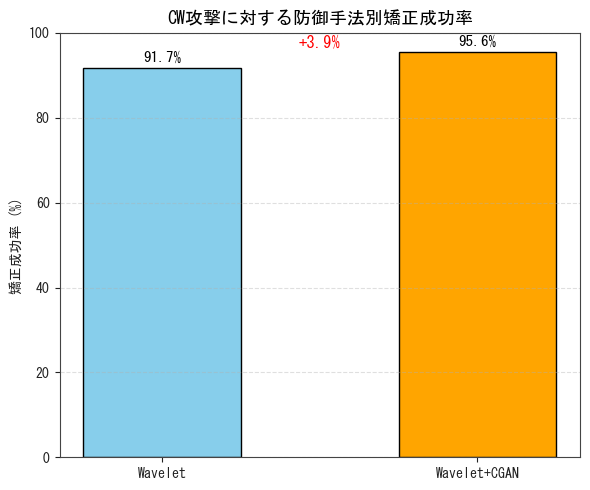

✅ グラフを保存しました: C:\Users\sit\wavelet_CGAN\testdata3\compare_all\data3\CW


In [35]:
# ==========================================================
# compare_*.csv（Wavelet+CGAN統合）専用スクリプト
# WaveletとCGANの矯正成功率比較（FGSM/CW共通）
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams["figure.facecolor"] = "white"

# === 入力CSV（例：compare_dataX_FGSM_Wavelet_CGAN.csv）===
csv_path = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\compare_all\data3\CW\compare_data3_CW_Wavelet_CGAN_fixed.csv")

# === CSV読み込み ===
df = pd.read_csv(csv_path)

# === 列チェック ===
if not {"RecoverySuccess_Wavelet", "RecoverySuccess_CGAN"} <= set(df.columns):
    raise ValueError("❌ このCSVに RecoverySuccess_Wavelet または RecoverySuccess_CGAN 列が存在しません。")

# === 成功率算出 ===
total = len(df)
wavelet_success = df["RecoverySuccess_Wavelet"].sum()
cgan_success = df["RecoverySuccess_CGAN"].sum()
wavelet_rate = wavelet_success / total * 100
cgan_rate = cgan_success / total * 100
improve = cgan_rate - wavelet_rate

# === 結果表示 ===
print("=== 成功率比較 ===")
print(f"Wavelet: {wavelet_rate:.2f}% ({wavelet_success}/{total})")
print(f"Wavelet+CGAN: {cgan_rate:.2f}% ({cgan_success}/{total})")
print(f"改善率: +{improve:.2f}%")

# === 結果表 ===
summary = pd.DataFrame({
    "防御手法": ["Wavelet", "Wavelet+CGAN", "改善率(差分)"],
    "矯正成功率(%)": [round(wavelet_rate, 2), round(cgan_rate, 2), f"+{round(improve, 2)}"]
})
out_dir = csv_path.parent
summary_path = out_dir / "FGSM_Compare_Wavelet_vs_CGAN.csv"
summary.to_csv(summary_path, index=False, encoding="utf-8-sig")
print(f"✅ 成功率比較表を出力しました: {summary_path}")

# === グラフ出力 ===
plt.figure(figsize=(6,5))
bars = plt.bar(["Wavelet", "Wavelet+CGAN"], [wavelet_rate, cgan_rate],
               color=["skyblue", "orange"], edgecolor="black", width=0.5)
plt.title("CW攻撃に対する防御手法別矯正成功率", fontsize=13, weight="bold")
plt.ylabel("矯正成功率 (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# 値ラベル
for i, bar in enumerate(bars):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 1, f"{h:.1f}%", ha="center", va="bottom", fontsize=11, weight="bold")

# 改善率を中央に赤字で
plt.text(0.5, (wavelet_rate + cgan_rate)/2 + 3, f"+{improve:.1f}%", color="red", fontsize=12, ha="center", weight="bold")

plt.tight_layout()
plt.savefig(out_dir / "FGSM_Wavelet_vs_CGAN_Compare.png", dpi=400)
plt.show()

print(f"✅ グラフを保存しました: {out_dir}")


C:\Users\sit\AppData\Local\Temp\ipykernel_29876\1749105218.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wavelet_stats = df.groupby("Wavelet_conf_bin")["RecoverySuccess_Wavelet"].mean() * 100
C:\Users\sit\AppData\Local\Temp\ipykernel_29876\1749105218.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cgan_stats = df.groupby("CGAN_conf_bin")["RecoverySuccess_CGAN"].mean() * 100


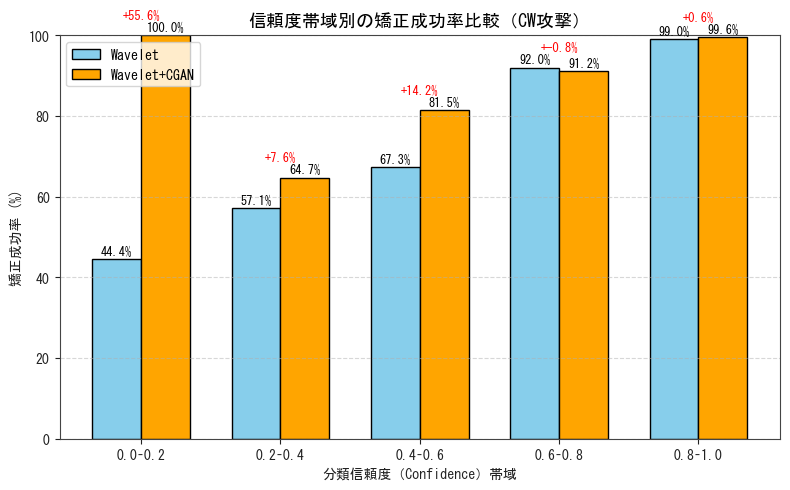

✅ 棒グラフを出力しました: C:\Users\sit\wavelet_CGAN\testdata3\compare_all\data3\CW\CW_ConfidenceBand_Compare_Bar.png
✅ 分析表を出力しました: C:\Users\sit\wavelet_CGAN\testdata3\compare_all\data3\CW\CW_ConfidenceBand_Summary_Bar.csv


In [42]:
# ==========================================================
# Wavelet vs CGAN：confidence帯域別 矯正成功率比較（棒グラフ版）
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams["figure.facecolor"] = "white"

# === 入力CSV ===
csv_path = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\compare_all\data3\CW\compare_data3_CW_Wavelet_CGAN_fixed.csv")
df = pd.read_csv(csv_path)

# === 必要列チェック ===
required_cols = ["Wavelet_Confidence", "CGAN_Confidence", "RecoverySuccess_Wavelet", "RecoverySuccess_CGAN"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ 以下の列がCSVに見つかりません: {missing}")

# === confidence帯域 ===
bins = np.linspace(0, 1, 6)  # 0.0〜1.0を5分割
labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins)-1)]

df["Wavelet_conf_bin"] = pd.cut(df["Wavelet_Confidence"], bins=bins, labels=labels, include_lowest=True)
df["CGAN_conf_bin"] = pd.cut(df["CGAN_Confidence"], bins=bins, labels=labels, include_lowest=True)

# === 帯域別成功率 ===
wavelet_stats = df.groupby("Wavelet_conf_bin")["RecoverySuccess_Wavelet"].mean() * 100
cgan_stats = df.groupby("CGAN_conf_bin")["RecoverySuccess_CGAN"].mean() * 100
improve = cgan_stats - wavelet_stats

# === 可視化（棒グラフ）===
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, wavelet_stats.values, width, label="Wavelet", color="skyblue", edgecolor="black")
plt.bar(x + width/2, cgan_stats.values, width, label="Wavelet+CGAN", color="orange", edgecolor="black")

# ラベルとタイトル
plt.title("信頼度帯域別の矯正成功率比較（CW攻撃）", fontsize=13, weight="bold")
plt.xlabel("分類信頼度（Confidence）帯域")
plt.ylabel("矯正成功率 (%)")
plt.xticks(x, labels)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 数値ラベル（成功率と改善率）
for i, (w, g) in enumerate(zip(wavelet_stats.values, cgan_stats.values)):
    plt.text(i - width/2, w + 1, f"{w:.1f}%", ha="center", fontsize=9)
    plt.text(i + width/2, g + 1, f"{g:.1f}%", ha="center", fontsize=9)
    plt.text(i, max(w,g) + 4, f"+{(g-w):.1f}%", ha="center", color="red", fontsize=9, weight="bold")

plt.tight_layout()

# === 保存 ===
out_dir = csv_path.parent
out_path = out_dir / "CW_ConfidenceBand_Compare_Bar.png"
plt.savefig(out_path, dpi=400)
plt.show()

print(f"✅ 棒グラフを出力しました: {out_path}")

# === 表も保存 ===
summary = pd.DataFrame({
    "Confidence帯域": labels,
    "Wavelet成功率(%)": wavelet_stats.values,
    "CGAN成功率(%)": cgan_stats.values,
    "改善率(差分)(%)": improve.values
})
summary_path = out_dir / "CW_ConfidenceBand_Summary_Bar.csv"
summary.to_csv(summary_path, index=False, encoding="utf-8-sig")
print(f"✅ 分析表を出力しました: {summary_path}")


攻撃前平均: 0.855, 攻撃後平均: 0.661, CGAN後平均: 0.702
総失敗数: 83


C:\Users\sit\AppData\Local\Temp\ipykernel_25188\3174899276.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stages, y=means, palette=colors)


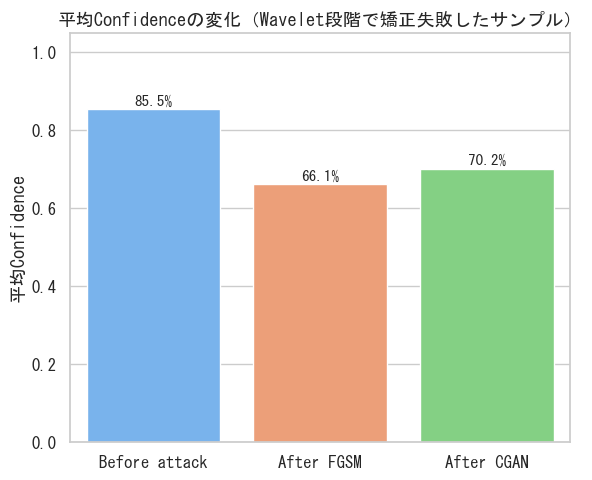

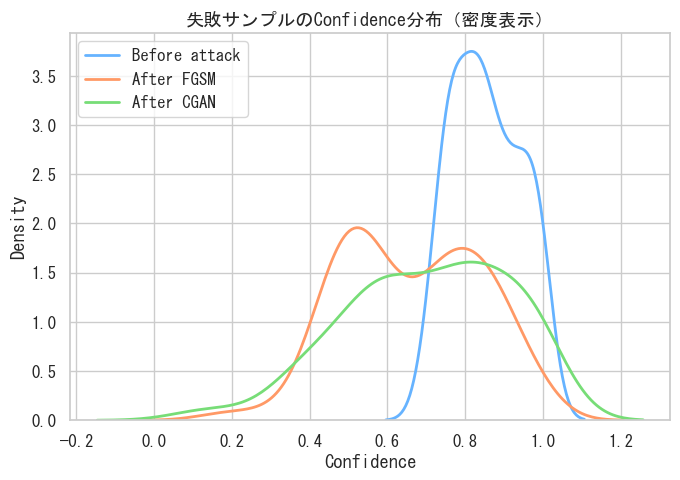

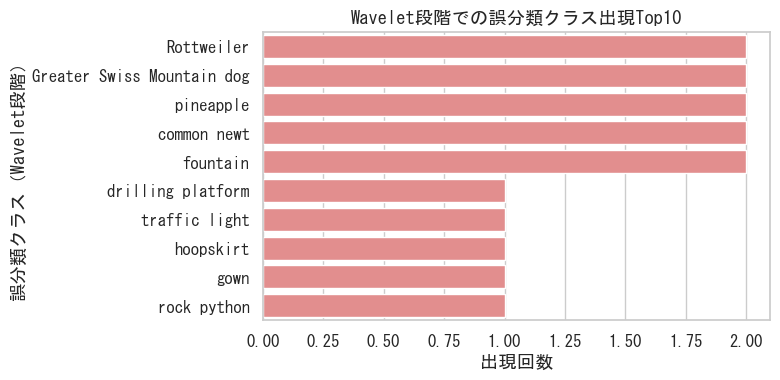

✅ Confidence平均・分布・誤分類Top10を出力しました。
📁 出力フォルダ: C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data3_CW


In [2]:
# ==========================================================
# 改良版：失敗サンプルのConfidence比較＋誤分類出現回数（Wavelet失敗）
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# === CSV読み込み ===
csv_path = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data3_CW\failed_lists_data3_CW.csv")
df = pd.read_csv(csv_path)
fail_wavelet = df[df["FailStage"] == "Wavelet"]

# === Seabornスタイル設定 ===
sns.set(style="whitegrid", font="MS Gothic", font_scale=1.1)

# === 各段階の平均値 ===
mean_before = fail_wavelet["confidence_before"].mean()
mean_after = fail_wavelet["confidence_after"].mean()
mean_cgan = fail_wavelet["CGAN_Confidence"].mean()

print(f"攻撃前平均: {mean_before:.3f}, 攻撃後平均: {mean_after:.3f}, CGAN後平均: {mean_cgan:.3f}")
print(f"総失敗数: {len(fail_wavelet)}")

# === 1. 平均バー比較 ===
plt.figure(figsize=(6,5))
stages = ["Before attack", "After FGSM", "After CGAN"]
means = [mean_before, mean_after, mean_cgan]
colors = ["#66b3ff", "#ff9966", "#77dd77"]

sns.barplot(x=stages, y=means, palette=colors)
for i, v in enumerate(means):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', fontsize=11)
plt.ylim(0, 1.05)
plt.title("平均Confidenceの変化（Wavelet段階で矯正失敗したサンプル）")
plt.ylabel("平均Confidence")
plt.tight_layout()
plt.savefig(csv_path.parent / "Fail_Confidence_MeanBar.png", dpi=300)
plt.show()

# === 2. 分布線グラフ（KDE） ===
plt.figure(figsize=(7,5))
sns.kdeplot(fail_wavelet["confidence_before"], color="#66b3ff", label="Before attack", linewidth=2)
sns.kdeplot(fail_wavelet["confidence_after"], color="#ff9966", label="After FGSM", linewidth=2)
sns.kdeplot(fail_wavelet["CGAN_Confidence"], color="#77dd77", label="After CGAN", linewidth=2)
plt.title("失敗サンプルのConfidence分布（密度表示）")
plt.xlabel("Confidence")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(csv_path.parent / "Fail_Confidence_Density.png", dpi=300)
plt.show()

# === 3. 誤分類クラス出現回数（Top10） ===
fail_labels = Counter(fail_wavelet["Wavelet_Label"]).most_common(10)
classes, counts = zip(*fail_labels)

plt.figure(figsize=(8,4))
sns.barplot(x=list(counts), y=list(classes), color="lightcoral")
plt.title("Wavelet段階での誤分類クラス出現Top10")
plt.xlabel("出現回数")
plt.ylabel("誤分類クラス（Wavelet段階）")
plt.tight_layout()
plt.savefig(csv_path.parent / "Fail_Wavelet_Top10.png", dpi=300)
plt.show()

# === 4. 結果CSV（誤分類ペア一覧） ===
pairs_out = fail_wavelet[["ImageId", "label_name_before", "Wavelet_Label", "CGAN_Label", 
                          "confidence_before", "confidence_after", "CGAN_Confidence"]]
pairs_out.to_csv(csv_path.parent / "Fail_Wavelet_Pairs.csv", index=False, encoding="utf-8-sig")

print("✅ Confidence平均・分布・誤分類Top10を出力しました。")
print(f"📁 出力フォルダ: {csv_path.parent}")


In [6]:
# ==========================================================
# 改良版：失敗サンプルのConfidence比較＋誤分類出現回数
# （Wavelet / CGAN両対応・凡例修正版）
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# === CSV読み込み ===
csv_path = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data2_FGSM\failed_lists_data2_FGSM.csv")
df = pd.read_csv(csv_path)

# === Seabornスタイル設定 ===
sns.set(style="whitegrid", font="MS Gothic", font_scale=1.1)

# === FailStageの確認 ===
print("=== FailStage の内訳 ===")

print(df["FailStage"].value_counts(), "\n")

# === 解析関数 ===
def analyze_fail_stage(stage_name):
    fail_df = df[df["FailStage"] == stage_name]
    if len(fail_df) == 0:
        print(f"⚠ {stage_name} の失敗サンプルはありません。")
        return

    # === 平均値計算 ===
    mean_before = fail_df["confidence_before"].mean()
    mean_after = fail_df["confidence_after"].mean()
    mean_cgan = fail_df["CGAN_Confidence"].mean()

    print(f"\n=== {stage_name}段階の失敗解析 ===")
    print(f"攻撃前平均: {mean_before:.3f}, 攻撃後平均: {mean_after:.3f}, CGAN後平均: {mean_cgan:.3f}")
    print(f"総失敗数: {len(fail_df)}")

    # === 1. 平均バー比較 ===
    plt.figure(figsize=(6,5))
    if stage_name == "Wavelet":
        stages = ["Before attack", "After Wavelet"]
        means = [mean_before, mean_after]
        colors = ["#66b3ff", "#ff9966"]
    else:  # CGAN段階
        stages = ["Before attack", "After attack", "After CGAN"]
        means = [mean_before, mean_after, mean_cgan]
        colors = ["#66b3ff", "#ff9966", "#77dd77"]

    sns.barplot(x=stages, y=means, palette=colors)
    for i, v in enumerate(means):
        plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', fontsize=11)
    plt.ylim(0, 1.05)
    plt.title(f"平均Confidenceの変化（{stage_name}段階で矯正失敗したサンプル）")
    plt.ylabel("平均Confidence")
    plt.tight_layout()
    plt.savefig(csv_path.parent / f"Fail_{stage_name}_Confidence_MeanBar.png", dpi=300)
    plt.close()

    # === 2. 分布線グラフ ===
    plt.figure(figsize=(7,5))
    sns.kdeplot(fail_df["confidence_before"], color="#66b3ff", label="Before attack", linewidth=2)

    if stage_name == "Wavelet":
        sns.kdeplot(fail_df["confidence_after"], color="#ff9966", label="After Wavelet", linewidth=2)
    else:
        sns.kdeplot(fail_df["confidence_after"], color="#ff9966", label="After attack", linewidth=2)
        sns.kdeplot(fail_df["CGAN_Confidence"], color="#77dd77", label="After CGAN", linewidth=2)

    plt.title(f"{stage_name}段階での失敗サンプルのConfidence分布（密度表示）")
    plt.xlabel("Confidence")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(csv_path.parent / f"Fail_{stage_name}_Confidence_Density.png", dpi=300)
    plt.close()

    # === 3. 誤分類クラス出現回数 ===
    label_col = "Wavelet_Label" if stage_name == "Wavelet" else "CGAN_Label"
    fail_labels = Counter(fail_df[label_col]).most_common(10)
    if fail_labels:
        classes, counts = zip(*fail_labels)
        plt.figure(figsize=(8,4))
        sns.barplot(x=list(counts), y=list(classes), color="lightcoral")
        plt.title(f"{stage_name}段階での誤分類クラス出現Top10")
        plt.xlabel("出現回数")
        plt.ylabel("誤分類クラス")
        plt.tight_layout()
        plt.savefig(csv_path.parent / f"Fail_{stage_name}_Top10.png", dpi=300)
        plt.close()

    # === 4. 結果CSV出力 ===
    out_csv = csv_path.parent / f"Fail_{stage_name}_Pairs.csv"
    fail_df[["ImageId", "label_name_before", "Wavelet_Label", "CGAN_Label",
             "confidence_before", "confidence_after", "CGAN_Confidence"]].to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"✅ {stage_name}段階の出力完了: {out_csv}")

# === 実行（Wavelet / CGAN 両方） ===
for stage in ["Wavelet", "CGAN"]:
    analyze_fail_stage(stage)

print(f"\n📁 すべての出力フォルダ: {csv_path.parent}")


=== FailStage の内訳 ===
FailStage
Wavelet    190
CGAN        74
Name: count, dtype: int64 


=== Wavelet段階の失敗解析 ===
攻撃前平均: 0.866, 攻撃後平均: 0.597, CGAN後平均: 0.626
総失敗数: 190


C:\Users\sit\AppData\Local\Temp\ipykernel_25188\1865072697.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stages, y=means, palette=colors)


✅ Wavelet段階の出力完了: C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data2_FGSM\Fail_Wavelet_Pairs.csv

=== CGAN段階の失敗解析 ===
攻撃前平均: 0.851, 攻撃後平均: 0.580, CGAN後平均: 0.491
総失敗数: 74


C:\Users\sit\AppData\Local\Temp\ipykernel_25188\1865072697.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stages, y=means, palette=colors)


✅ CGAN段階の出力完了: C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data2_FGSM\Fail_CGAN_Pairs.csv

📁 すべての出力フォルダ: C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data2_FGSM


In [13]:
# ==========================================================
# 改良版：失敗サンプルのConfidence比較＋誤分類出現回数
# （After FGSM → After Wavelet に修正済み・Wavelet/CGAN両対応）
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# === CSV読み込み ===
csv_path = Path(r"C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data2_CW\failed_lists_data2_CW.csv")
df = pd.read_csv(csv_path)

# === Seabornスタイル設定 ===
sns.set(style="whitegrid", font="MS Gothic", font_scale=1.1)

# === FailStageの確認 ===
print("=== FailStage の内訳 ===")
print(df["FailStage"].value_counts(), "\n")

# === 解析関数 ===
def analyze_fail_stage(stage_name):
    fail_df = df[df["FailStage"] == stage_name]
    if len(fail_df) == 0:
        print(f"⚠ {stage_name} の失敗サンプルはありません。")
        return

    # === 平均値計算 ===
    mean_before = fail_df["confidence_before"].mean()
    mean_after = fail_df["confidence_after"].mean()
    mean_cgan = fail_df["CGAN_Confidence"].mean()

    print(f"\n=== {stage_name}段階の失敗解析 ===")
    print(f"攻撃前平均: {mean_before:.3f}, Wavelet後平均: {mean_after:.3f}, CGAN後平均: {mean_cgan:.3f}")
    print(f"総失敗数: {len(fail_df)}")

    # === 1. 平均バー比較 ===
    plt.figure(figsize=(6,5))
    if stage_name == "Wavelet":
        stages = ["Before attack", "After Wavelet"]
        means = [mean_before, mean_after]
        colors = ["#66b3ff", "#ff9966"]
    else:  # CGAN段階
        stages = ["Before attack", "After Wavelet", "After CGAN"]
        means = [mean_before, mean_after, mean_cgan]
        colors = ["#66b3ff", "#ff9966", "#77dd77"]

    sns.barplot(x=stages, y=means, palette=colors)
    for i, v in enumerate(means):
        plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', fontsize=11)
    plt.ylim(0, 1.05)
    plt.title(f"平均Confidenceの変化（{stage_name}段階で矯正失敗したサンプル）")
    plt.ylabel("平均Confidence")
    plt.tight_layout()
    plt.savefig(csv_path.parent / f"Fail_{stage_name}_Confidence_MeanBar.png", dpi=300)
    plt.close()

    # === 2. 分布線グラフ ===
    plt.figure(figsize=(7,5))
    sns.kdeplot(fail_df["confidence_before"], color="#66b3ff", label="Before attack", linewidth=2)

    if stage_name == "Wavelet":
        sns.kdeplot(fail_df["confidence_after"], color="#ff9966", label="After Wavelet", linewidth=2)
    else:
        sns.kdeplot(fail_df["confidence_after"], color="#ff9966", label="After Wavelet", linewidth=2)
        sns.kdeplot(fail_df["CGAN_Confidence"], color="#77dd77", label="After CGAN", linewidth=2)

    plt.title(f"{stage_name}段階での失敗サンプルのConfidence分布（密度表示）")
    plt.xlabel("Confidence")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(csv_path.parent / f"Fail_{stage_name}_Confidence_Density.png", dpi=300)
    plt.close()

    # === 3. 誤分類クラス出現回数 ===
    label_col = "Wavelet_Label" if stage_name == "Wavelet" else "CGAN_Label"
    fail_labels = Counter(fail_df[label_col]).most_common(10)
    if fail_labels:
        classes, counts = zip(*fail_labels)
        plt.figure(figsize=(8,4))
        sns.barplot(x=list(counts), y=list(classes), color="lightcoral")
        plt.title(f"{stage_name}段階での誤分類クラス出現Top10")
        plt.xlabel("出現回数")
        plt.ylabel("誤分類クラス")
        plt.tight_layout()
        plt.savefig(csv_path.parent / f"Fail_{stage_name}_Top10.png", dpi=300)
        plt.close()

    # === 4. 結果CSV出力 ===
    out_csv = csv_path.parent / f"Fail_{stage_name}_Pairs.csv"
    fail_df[["ImageId", "label_name_before", "Wavelet_Label", "CGAN_Label",
             "confidence_before", "confidence_after", "CGAN_Confidence"]].to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"✅ {stage_name}段階の出力完了: {out_csv}")

# === 実行（Wavelet / CGAN 両方） ===
for stage in ["Wavelet", "CGAN"]:
    analyze_fail_stage(stage)

print(f"\n📁 すべての出力フォルダ: {csv_path.parent}")


=== FailStage の内訳 ===
FailStage
Wavelet    97
CGAN       38
Name: count, dtype: int64 


=== Wavelet段階の失敗解析 ===
攻撃前平均: 0.875, Wavelet後平均: 0.624, CGAN後平均: 0.704
総失敗数: 97


C:\Users\sit\AppData\Local\Temp\ipykernel_25188\1205954548.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stages, y=means, palette=colors)


✅ Wavelet段階の出力完了: C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data2_CW\Fail_Wavelet_Pairs.csv

=== CGAN段階の失敗解析 ===
攻撃前平均: 0.840, Wavelet後平均: 0.586, CGAN後平均: 0.426
総失敗数: 38


C:\Users\sit\AppData\Local\Temp\ipykernel_25188\1205954548.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stages, y=means, palette=colors)


✅ CGAN段階の出力完了: C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data2_CW\Fail_CGAN_Pairs.csv

📁 すべての出力フォルダ: C:\Users\sit\wavelet_CGAN\testdata3\cgan_restore_failed\data2_CW


In [18]:
# -*- coding: utf-8 -*-
# ==========================================================
# 失敗サンプルの LayerCAM 可視化（FGSM / CW × Wavelet / Wavelet+CGAN）
# - Tensorファイル（.pt）を直接読み込み
# - CSVのラベル・信頼度を図中タイトルに表示
# - Wavelet段階ではモデル出力から信頼度を再算出
# ==========================================================
import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt

# ==========================================================
# ユーザ設定
# ==========================================================
BASE      = Path(r"C:\Users\sit\wavelet_CGAN\testdata3")
dataset   = "data3"
attack    = "CW"
analysis  = "cgan"        # "wavelet" または "cgan"
failed_csv = BASE / "cgan_restore_failed" / f"{dataset}_{attack}" / f"failed_lists_{dataset}_{attack}.csv"

N_SAMPLES = 10
OUTDIR = BASE / "layercam_vis_tensor" / f"{dataset}_{attack}_{analysis}"
OUTDIR.mkdir(parents=True, exist_ok=True)

CONVERT_01_TO_MINUS11 = False

# ==========================================================
# Tensor探索関数
# ==========================================================
def load_first_exist(paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

def find_clean_tensor(image_id):
    return load_first_exist([BASE/f"{dataset}_clean_tensor"/f"{image_id}.pt"])

def find_attacked_tensor(image_id, attack):
    return load_first_exist([BASE/f"{dataset}_{attack}"/"tensor"/f"{image_id}.pt"])

def find_wavelet_tensor(image_id, attack):
    cands = [
        BASE/f"{dataset}_{attack}"/"wavelet_eval"/"wavelet_tensor"/f"{image_id}.pt",
        BASE/f"{dataset}_{attack}"/"wavelet_eval"/"wavelet_tensor"/f"{image_id}_wavelet.pt"
    ]
    return load_first_exist(cands)

def find_cgan_tensor(image_id, attack):
    cands = [
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}.pt",
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_restored.pt",
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_{attack}_restored.pt",
    ]
    return load_first_exist(cands)

# ==========================================================
# LayerCAM 実装
# ==========================================================
class LayerCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, target=None):
        x = x.requires_grad_(True)
        logits = self.model(x)
        if target is None:
            target = logits.argmax(dim=1)
        loss = logits[:, target].sum()
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        weights = F.relu(self.gradients)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.squeeze(1).cpu(), logits.detach()

def overlay_cam(tensor_img, cam, alpha=0.4):
    import matplotlib.cm as cm
    from PIL import Image
    img = tensor_img.detach().squeeze().permute(1,2,0).cpu()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    heat = (cm.jet(cam.numpy())[:,:,:3]*255).astype("uint8")
    base = (img.numpy()*255).astype("uint8")
    base = Image.fromarray(base)
    heat = Image.fromarray(heat)
    return Image.blend(base, heat, alpha)

# ==========================================================
# モデル設定
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights).to(device)
target_layer = model.features[14]
layercam = LayerCAM(model, target_layer)

# ==========================================================
# CSV読み込み
# ==========================================================
df = pd.read_csv(failed_csv)
stage_needed = "Wavelet" if analysis=="wavelet" else "CGAN"
df = df[df["FailStage"]==stage_needed].copy()
if len(df)==0:
    raise SystemExit(f"[ERROR] {failed_csv} に {stage_needed} 失敗サンプルがありません。")

# ==========================================================
# Tensor読み込み
# ==========================================================
def tensor_from_saved_pt(path):
    t = torch.load(path, map_location=device)
    if t.ndim == 3:
        t = t.unsqueeze(0)
    if CONVERT_01_TO_MINUS11 and t.max() <= 1.0:
        t = t * 2 - 1
    return t

# ==========================================================
# ラベル・信頼度取得関数
# ==========================================================
def get_label_conf(row, stage):
    """CSV行データからステージに対応するラベルと信頼度を取得"""
    if stage == "Before":
        label = row.get("label_name_before", "N/A")
        conf = row.get("confidence_before", None)
    elif stage == "After attack":
        label = row.get("Advs_label_name", "N/A")
        conf = row.get("confidence_after", None)
    elif stage == "After Wavelet":
        label = row.get("Wavelet_Label", "N/A")
        conf = row.get("Wavelet_Confidence", None)
    elif stage == "After CGAN":
        label = row.get("CGAN_Label", "N/A")
        conf = row.get("CGAN_Confidence", None)
    else:
        label, conf = "N/A", None
    # クラス名補正
    if isinstance(label, str) and label.startswith("class_"):
        try:
            idx = int(label.split("_")[1])
            label = weights.meta["categories"][idx]
        except:
            pass
    return label, conf

# ==========================================================
# 可視化ループ
# ==========================================================
ids = df["ImageId"].astype(str).tolist()[:N_SAMPLES]

for image_id in ids:
    clean_p  = find_clean_tensor(image_id)
    adv_p    = find_attacked_tensor(image_id, attack)
    wav_p    = find_wavelet_tensor(image_id, attack)
    cgan_p   = find_cgan_tensor(image_id, attack)

    panels = [("Before", clean_p), ("After attack", adv_p),
              ("After Wavelet", wav_p)] if analysis=="wavelet" else \
             [("Before", clean_p), ("After attack", adv_p),
              ("After CGAN", cgan_p)]

    fig, axes = plt.subplots(2, len(panels), figsize=(4*len(panels), 6))
    fig.suptitle(f"{dataset} / {attack} / LayerCAM ({analysis.upper()}) : {image_id}", fontsize=12)

    row = df[df["ImageId"] == image_id].iloc[0]

    for j, (title, pth) in enumerate(panels):
        if pth is None:
            axes[0,j].set_title(f"{title}\n(Not found)")
            axes[0,j].axis("off"); axes[1,j].axis("off")
            continue

        x = tensor_from_saved_pt(pth)
        cam, _ = layercam(x)
        overlay = overlay_cam(x, cam[0])

        # === ラベルと信頼度 ===
        label, conf = get_label_conf(row, title)
        label_text = f"{label} ({conf:.2f})" if conf is not None else label

        # === 表示用補正 ===
        img_vis = x.detach().squeeze().permute(1,2,0).cpu()
        if img_vis.min() < 0:
            img_vis = (img_vis + 1) / 2.0
        img_vis = torch.clamp(img_vis, 0, 1)

        axes[0,j].imshow(img_vis)
        axes[0,j].set_title(f"{title}\n{label_text}", fontsize=9)
        axes[0,j].axis("off")

        axes[1,j].imshow(overlay)
        axes[1,j].set_title(f"{title} + LayerCAM", fontsize=9)
        axes[1,j].axis("off")

    plt.tight_layout()
    out = OUTDIR / f"{image_id}_{analysis}_{attack}_LayerCAM_label.png"
    plt.savefig(out, dpi=220)
    plt.close(fig)
    print(f"✅ LayerCAM saved with labels: {out}")

print(f"\n📁 出力フォルダ: {OUTDIR}")
print("ヒント: features[12]～[15] を変えて比較すると反応領域が変わります。")



✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sample0032_cgan_CW_GradCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sample0061_cgan_CW_GradCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sample0071_cgan_CW_GradCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sample0083_cgan_CW_GradCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sample0086_cgan_CW_GradCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sample0093_cgan_CW_GradCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sample0133_cgan_CW_GradCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sample0145_cgan_CW_GradCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\gradcam_vis_tensor\data3_CW_cgan\sa

In [31]:
# -*- coding: utf-8 -*-
# ==========================================================
# 失敗サンプルの LayerCAM 可視化（FGSM / CW × Wavelet / Wavelet+CGAN）
# - Tensorファイル（.pt）を直接読み込み
# - CSVのラベル・信頼度を図中タイトルに表示（NA時は自動再推論で補完）
# ==========================================================
import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt

# ==========================================================
# ユーザ設定
# ==========================================================
BASE      = Path(r"C:\Users\sit\wavelet_CGAN\testdata3")
dataset   = "data2"
attack    = "CW"
analysis  = "wavelet"        # "wavelet" または "cgan"
failed_csv = BASE / "cgan_restore_failed" / f"{dataset}_{attack}" / f"failed_lists_{dataset}_{attack}.csv"

N_SAMPLES = 10
OUTDIR = BASE / "layercam_vis_tensor" / f"{dataset}_{attack}_{analysis}"
OUTDIR.mkdir(parents=True, exist_ok=True)

CONVERT_01_TO_MINUS11 = False

# ==========================================================
# Tensor探索関数
# ==========================================================
def load_first_exist(paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

def find_clean_tensor(image_id):
    return load_first_exist([BASE/f"{dataset}_clean_tensor"/f"{image_id}.pt"])

def find_attacked_tensor(image_id, attack):
    return load_first_exist([BASE/f"{dataset}_{attack}"/"tensor"/f"{image_id}.pt"])

def find_wavelet_tensor(image_id, attack):
    cands = [
        BASE/f"{dataset}_{attack}"/"wavelet_eval"/"wavelet_tensor"/f"{image_id}.pt",
        BASE/f"{dataset}_{attack}"/"wavelet_eval"/"wavelet_tensor"/f"{image_id}_wavelet.pt"
    ]
    return load_first_exist(cands)

def find_cgan_tensor(image_id, attack):
    cands = [
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}.pt",
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_restored.pt",
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_{attack}_restored.pt",
    ]
    return load_first_exist(cands)

# ==========================================================
# LayerCAM 実装
# ==========================================================
class LayerCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, target=None):
        x = x.requires_grad_(True)
        logits = self.model(x)
        if target is None:
            target = logits.argmax(dim=1)
        loss = logits[:, target].sum()
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        weights = F.relu(self.gradients)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.squeeze(1).cpu(), logits.detach()

def overlay_cam(tensor_img, cam, alpha=0.4):
    import matplotlib.cm as cm
    from PIL import Image
    img = tensor_img.detach().squeeze().permute(1,2,0).cpu()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    heat = (cm.jet(cam.numpy())[:,:,:3]*255).astype("uint8")
    base = (img.numpy()*255).astype("uint8")
    base = Image.fromarray(base)
    heat = Image.fromarray(heat)
    return Image.blend(base, heat, alpha)

# ==========================================================
# モデル設定
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights).to(device)
target_layer = model.features[14]
layercam = LayerCAM(model, target_layer)

# ==========================================================
# CSV読み込み
# ==========================================================
df = pd.read_csv(failed_csv)
stage_needed = "Wavelet" if analysis=="wavelet" else "CGAN"
df = df[df["FailStage"]==stage_needed].copy()
if len(df)==0:
    raise SystemExit(f"[ERROR] {failed_csv} に {stage_needed} 失敗サンプルがありません。")

# ==========================================================
# Tensor読み込み
# ==========================================================
def tensor_from_saved_pt(path):
    t = torch.load(path, map_location=device)
    if t.ndim == 3:
        t = t.unsqueeze(0)
    if CONVERT_01_TO_MINUS11 and t.max() <= 1.0:
        t = t * 2 - 1
    return t

# ==========================================================
# ラベル・信頼度取得関数（NA補完対応）
# ==========================================================
def get_label_conf(row, stage, x_tensor=None):
    """CSV行データからステージに対応するラベルと信頼度を取得（NAはモデル再推論で補完）"""
    if stage == "Before":
        label = row.get("label_name_before", None)
        conf = row.get("confidence_before", None)
    elif stage == "After attack":
        label = row.get("Advs_label_name", None)
        conf = row.get("confidence_after", None)
    elif stage == "After Wavelet":
        label = row.get("Wavelet_Label", None)
        conf = row.get("Wavelet_Confidence", None)
    elif stage == "After CGAN":
        label = row.get("CGAN_Label", None)
        conf = row.get("CGAN_Confidence", None)
    else:
        label, conf = None, None

    # --- class_xxx → カテゴリ変換 ---
    if isinstance(label, str) and label.startswith("class_"):
        try:
            idx = int(label.split("_")[1])
            label = weights.meta["categories"][idx]
        except Exception:
            pass

    # --- None や N/A の場合、自動でモデル再推論 ---
    if (label is None or label == "N/A" or conf is None) and x_tensor is not None:
        with torch.no_grad():
            logits = model(x_tensor)
            probs = F.softmax(logits, dim=1)
            conf_val, pred = probs.max(dim=1)
            label = weights.meta["categories"][pred.item()]
            conf = conf_val.item()

    return label, conf

# ==========================================================
# 可視化ループ
# ==========================================================
ids = df["ImageId"].astype(str).tolist()[:N_SAMPLES]

for image_id in ids:
    clean_p  = find_clean_tensor(image_id)
    adv_p    = find_attacked_tensor(image_id, attack)
    wav_p    = find_wavelet_tensor(image_id, attack)
    cgan_p   = find_cgan_tensor(image_id, attack)

    panels = [("Before", clean_p), ("After attack", adv_p),
              ("After Wavelet", wav_p)] if analysis=="wavelet" else \
             [("Before", clean_p), ("After attack", adv_p),
              ("After CGAN", cgan_p)]

    fig, axes = plt.subplots(2, len(panels), figsize=(4*len(panels), 6))
    fig.suptitle(f"{dataset} / {attack} / LayerCAM ({analysis.upper()}) : {image_id}", fontsize=12)

    row = df[df["ImageId"] == image_id].iloc[0]

    for j, (title, pth) in enumerate(panels):
        if pth is None:
            axes[0,j].set_title(f"{title}\n(Not found)")
            axes[0,j].axis("off"); axes[1,j].axis("off")
            continue

        x = tensor_from_saved_pt(pth)
        cam, _ = layercam(x)
        overlay = overlay_cam(x, cam[0])

        # === ラベルと信頼度（自動補完付き） ===
        label, conf = get_label_conf(row, title, x_tensor=x)
        label_text = f"{label} ({conf:.2f})" if conf is not None else label

        # === 表示用補正 ===
        img_vis = x.detach().squeeze().permute(1,2,0).cpu()
        if img_vis.min() < 0:
            img_vis = (img_vis + 1) / 2.0
        img_vis = torch.clamp(img_vis, 0, 1)

        axes[0,j].imshow(img_vis)
        axes[0,j].set_title(f"{title}\n{label_text}", fontsize=9)
        axes[0,j].axis("off")

        axes[1,j].imshow(overlay)
        axes[1,j].set_title(f"{title} + LayerCAM", fontsize=9)
        axes[1,j].axis("off")

    plt.tight_layout()
    out = OUTDIR / f"{image_id}_{analysis}_{attack}_LayerCAM_label.png"
    plt.savefig(out, dpi=220)
    plt.close(fig)
    print(f"✅ LayerCAM saved with labels: {out}")

print(f"\n📁 出力フォルダ: {OUTDIR}")
print("ヒント: NA時はモデルが自動で再推論し、クラス名と信頼度を補完します。")


✅ LayerCAM saved with labels: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_wavelet\sample0001_wavelet_CW_LayerCAM_label.png
✅ LayerCAM saved with labels: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_wavelet\sample0005_wavelet_CW_LayerCAM_label.png
✅ LayerCAM saved with labels: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_wavelet\sample0021_wavelet_CW_LayerCAM_label.png
✅ LayerCAM saved with labels: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_wavelet\sample0034_wavelet_CW_LayerCAM_label.png
✅ LayerCAM saved with labels: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_wavelet\sample0044_wavelet_CW_LayerCAM_label.png
✅ LayerCAM saved with labels: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_wavelet\sample0047_wavelet_CW_LayerCAM_label.png
✅ LayerCAM saved with labels: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_wavelet\sample0051_wavelet_CW_LayerCAM_la

In [50]:
# -*- coding: utf-8 -*-
# ==========================================================
# LayerCAM 可視化（Wavelet / CGAN 成功・失敗パターン別）
# - Tensorファイル（.pt）を直接読み込み
# - CSVの矯正結果（True/False）をもとに4カテゴリに分類
# - 攻撃手法別×防御手法別フォルダに保存
# ==========================================================
import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt

# ==========================================================
# ユーザ設定
# ==========================================================
BASE      = Path(r"C:\Users\sit\wavelet_CGAN\testdata3")
dataset   = "data2"
attack    = "CW"

# 🔹ここでCSVを指定
csv_path  = BASE / "compare_all" / dataset / attack / f"compare_{dataset}_{attack}_Wavelet_CGAN_fixed.csv" #CW
#csv_path  = BASE / "compare_all" / dataset / attack / f"compare_{dataset}_{attack}_Wavelet_CGAN.csv" #FGSM


N_SAMPLES = 10
CONVERT_01_TO_MINUS11 = False

# ==========================================================
# 出力フォルダ構造
# ==========================================================
BASE_OUT = BASE / "layercam_vis_tensor" / f"{dataset}_{attack}_pattern"
BASE_OUT.mkdir(parents=True, exist_ok=True)

PATTERNS = {
    "TT": BASE_OUT / "WaveletTrue_CGANTrue",
    "TF": BASE_OUT / "WaveletTrue_CGANFalse",
    "FT": BASE_OUT / "WaveletFalse_CGANTrue",
    "FF": BASE_OUT / "WaveletFalse_CGANFalse"
}
for p in PATTERNS.values():
    p.mkdir(parents=True, exist_ok=True)

# ==========================================================
# Tensor探索関数
# ==========================================================
def load_first_exist(paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

def find_clean_tensor(image_id):
    return load_first_exist([BASE/f"{dataset}_clean_tensor"/f"{image_id}.pt"])

def find_attacked_tensor(image_id, attack):
    return load_first_exist([BASE/f"{dataset}_{attack}"/"tensor"/f"{image_id}.pt"])

def find_wavelet_tensor(image_id, attack):
    cands = [
        BASE/f"{dataset}_{attack}"/"wavelet_eval"/"wavelet_tensor"/f"{image_id}.pt",
        BASE/f"{dataset}_{attack}"/"wavelet_eval"/"wavelet_tensor"/f"{image_id}_wavelet.pt"
    ]
    return load_first_exist(cands)

def find_cgan_tensor(image_id, attack):
    cands = [
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}.pt",
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_restored.pt",
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_{attack}_restored.pt",
    ]
    return load_first_exist(cands)

# ==========================================================
# LayerCAM 実装
# ==========================================================
class LayerCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, target=None):
        x = x.requires_grad_(True)
        logits = self.model(x)
        if target is None:
            target = logits.argmax(dim=1)
        loss = logits[:, target].sum()
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        weights = F.relu(self.gradients)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.squeeze(1).cpu(), logits.detach()

def overlay_cam(tensor_img, cam, alpha=0.4):
    import matplotlib.cm as cm
    from PIL import Image
    img = tensor_img.detach().squeeze().permute(1,2,0).cpu()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    heat = (cm.jet(cam.numpy())[:,:,:3]*255).astype("uint8")
    base = (img.numpy()*255).astype("uint8")
    base = Image.fromarray(base)
    heat = Image.fromarray(heat)
    return Image.blend(base, heat, alpha)

# ==========================================================
# モデル設定
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights).to(device)
target_layer = model.features[14]
layercam = LayerCAM(model, target_layer)

# ==========================================================
# CSV読み込み
# ==========================================================
df = pd.read_csv(csv_path)
print(f"Loaded CSV: {csv_path}")
print(df.columns.tolist())

# ==========================================================
# 4分類パターンを決定
# ==========================================================
def determine_pattern(row):
    w = row.get("RecoverySuccess_Wavelet", None)
    c = row.get("RecoverySuccess_CGAN", None)
    if pd.isna(w) or pd.isna(c):
        return None
    w = str(w).strip().upper() == "TRUE"
    c = str(c).strip().upper() == "TRUE"
    if w and c:
        return "TT"
    elif w and not c:
        return "TF"
    elif not w and c:
        return "FT"
    else:
        return "FF"

df["Pattern"] = df.apply(determine_pattern, axis=1)
df = df.dropna(subset=["Pattern"])
print(f"検出されたパターン数: {df['Pattern'].value_counts().to_dict()}")

# ==========================================================
# Tensor読み込み
# ==========================================================
def tensor_from_saved_pt(path):
    t = torch.load(path, map_location=device)
    if t.ndim == 3:
        t = t.unsqueeze(0)
    if CONVERT_01_TO_MINUS11 and t.max() <= 1.0:
        t = t * 2 - 1
    return t

# ==========================================================
# 可視化ループ
# ==========================================================
for pattern_key, outdir in PATTERNS.items():
    subset = df[df["Pattern"] == pattern_key].head(N_SAMPLES)
    if len(subset) == 0:
        continue

    print(f"\n=== {pattern_key} ({len(subset)} samples) ===")
    for _, row in subset.iterrows():
        image_id = str(row["ImageId"])
        clean_p  = find_clean_tensor(image_id)
        adv_p    = find_attacked_tensor(image_id, attack)
        wav_p    = find_wavelet_tensor(image_id, attack)
        cgan_p   = find_cgan_tensor(image_id, attack)

        panels = [
            ("Before", clean_p),
            ("After attack", adv_p),
            ("After Wavelet", wav_p),
            ("After CGAN", cgan_p)
        ]

        fig, axes = plt.subplots(2, len(panels), figsize=(4*len(panels), 6))
        fig.suptitle(f"{dataset} / {attack} / {pattern_key} : {image_id}", fontsize=12)

        for j, (title, pth) in enumerate(panels):
            if pth is None:
                axes[0,j].set_title(f"{title}\n(Not found)")
                axes[0,j].axis("off"); axes[1,j].axis("off")
                continue

            x = tensor_from_saved_pt(pth)
            cam, _ = layercam(x)
            overlay = overlay_cam(x, cam[0])

            img_vis = x.detach().squeeze().permute(1,2,0).cpu()
            if img_vis.min() < 0:
                img_vis = (img_vis + 1) / 2.0
            img_vis = torch.clamp(img_vis, 0, 1)

            axes[0,j].imshow(img_vis)
            axes[0,j].set_title(f"{title}", fontsize=9)
            axes[0,j].axis("off")

            axes[1,j].imshow(overlay)
            axes[1,j].set_title(f"{title} + LayerCAM", fontsize=9)
            axes[1,j].axis("off")

        plt.tight_layout()
        out = outdir / f"{image_id}_{attack}_{pattern_key}_LayerCAM.png"
        plt.savefig(out, dpi=220)
        plt.close(fig)
        print(f"✅ saved: {out}")

print("\n📁 出力先:")
for k, v in PATTERNS.items():
    print(f" {k}: {v}")


Loaded CSV: C:\Users\sit\wavelet_CGAN\testdata3\compare_all\data2\CW\compare_data2_CW_Wavelet_CGAN_fixed.csv
['image_x', 'label_id', 'label_name_before', 'confidence_before', 'ImageId', 'image_y', 'Original_label', 'Original_label_name', 'Original_confidence', 'Advs_label', 'label_name_after', 'confidence_after', 'L2_Distance', 'Tensor_path', 'Wavelet_Label', 'Wavelet_Confidence', 'CGAN_Label', 'CGAN_Confidence', 'AttackSuccess', 'RecoverySuccess_Wavelet', 'RecoverySuccess_CGAN']
検出されたパターン数: {'TT': 878, 'FT': 84, 'TF': 25, 'FF': 13}

=== TT (10 samples) ===
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_pattern\WaveletTrue_CGANTrue\sample0002_CW_TT_LayerCAM.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_pattern\WaveletTrue_CGANTrue\sample0003_CW_TT_LayerCAM.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_pattern\WaveletTrue_CGANTrue\sample0004_CW_TT_LayerCAM.png
✅ saved: C:\Users\sit\wavelet_CGAN\te

In [56]:
# -*- coding: utf-8 -*-
# ==========================================================
# LayerCAM 可視化（Wavelet / CGAN 成功・失敗パターン別）
# - Tensorファイル（.pt）を直接読み込み
# - CSVの矯正結果（True/False）をもとに4カテゴリに分類
# - CW攻撃後（After attack）のみ自動推論で補完
# ==========================================================
import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt

# ==========================================================
# ユーザ設定
# ==========================================================
BASE      = Path(r"C:\Users\sit\wavelet_CGAN\testdata3")
dataset   = "data2"
attack    = "CW"
csv_path  = BASE / "compare_all" / dataset / attack / f"compare_{dataset}_{attack}_Wavelet_CGAN_fixed.csv"
#csv_path  = BASE / "compare_all" / dataset / attack / f"compare_{dataset}_{attack}_Wavelet_CGAN.csv" #FGSM

N_SAMPLES = 10
CONVERT_01_TO_MINUS11 = False

# ==========================================================
# 出力フォルダ構造
# ==========================================================
BASE_OUT = BASE / "layercam_vis_tensor" / f"{dataset}_{attack}_pattern"
BASE_OUT.mkdir(parents=True, exist_ok=True)

PATTERNS = {
    "TT": BASE_OUT / "WaveletTrue_CGANTrue",
    "TF": BASE_OUT / "WaveletTrue_CGANFalse",
    "FT": BASE_OUT / "WaveletFalse_CGANTrue",
    "FF": BASE_OUT / "WaveletFalse_CGANFalse"
}
for p in PATTERNS.values():
    p.mkdir(parents=True, exist_ok=True)

# ==========================================================
# Tensor探索関数
# ==========================================================
def load_first_exist(paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

def find_clean_tensor(image_id):
    return load_first_exist([BASE/f"{dataset}_clean_tensor"/f"{image_id}.pt"])

def find_attacked_tensor(image_id, attack):
    return load_first_exist([BASE/f"{dataset}_{attack}"/"tensor"/f"{image_id}.pt"])

def find_wavelet_tensor(image_id, attack):
    cands = [
        BASE/f"{dataset}_{attack}"/"wavelet_eval"/"wavelet_tensor"/f"{image_id}.pt",
        BASE/f"{dataset}_{attack}"/"wavelet_eval"/"wavelet_tensor"/f"{image_id}_wavelet.pt"
    ]
    return load_first_exist(cands)

def find_cgan_tensor(image_id, attack):
    cands = [
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}.pt",
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_restored.pt",
        BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_{attack}_restored.pt",
    ]
    return load_first_exist(cands)

# ==========================================================
# LayerCAM 実装
# ==========================================================
class LayerCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, target=None):
        x = x.requires_grad_(True)
        logits = self.model(x)
        if target is None:
            target = logits.argmax(dim=1)
        loss = logits[:, target].sum()
        self.model.zero_grad()
        loss.backward(retain_graph=True)
        weights = F.relu(self.gradients)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.squeeze(1).cpu(), logits.detach()

def overlay_cam(tensor_img, cam, alpha=0.4):
    import matplotlib.cm as cm
    from PIL import Image
    img = tensor_img.detach().squeeze().permute(1,2,0).cpu()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    heat = (cm.jet(cam.numpy())[:,:,:3]*255).astype("uint8")
    base = (img.numpy()*255).astype("uint8")
    base = Image.fromarray(base)
    heat = Image.fromarray(heat)
    return Image.blend(base, heat, alpha)

# ==========================================================
# モデル設定（CAM生成および攻撃後補完用）
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights).to(device)
target_layer = model.features[14]
layercam = LayerCAM(model, target_layer)

# ==========================================================
# CSV読み込みと4分類作成
# ==========================================================
df = pd.read_csv(csv_path)
print(f"Loaded CSV: {csv_path}")
print(df.columns.tolist())

def determine_pattern(row):
    w = row.get("RecoverySuccess_Wavelet", None)
    c = row.get("RecoverySuccess_CGAN", None)
    if pd.isna(w) or pd.isna(c):
        return None
    w = str(w).strip().upper() == "TRUE"
    c = str(c).strip().upper() == "TRUE"
    if w and c:
        return "TT"
    elif w and not c:
        return "TF"
    elif not w and c:
        return "FT"
    else:
        return "FF"

df["Pattern"] = df.apply(determine_pattern, axis=1)
df = df.dropna(subset=["Pattern"])
print(f"検出されたパターン数: {df['Pattern'].value_counts().to_dict()}")

# ==========================================================
# CSVラベル・信頼度取得関数（攻撃後のみ再推論補完）
# ==========================================================
def get_label_conf(row, stage, x_tensor=None):
    label, conf = None, None
    if stage == "Before":
        label = row.get("Original_label_name", row.get("label_name_before", None))
        conf  = row.get("Original_confidence", row.get("confidence_before", None))
    elif stage == "After attack":
        label = row.get("Advs_label_name", None)
        conf  = row.get("Advs_confidence", row.get("confidence_after", None))
        # 🔹 CW攻撃後で欠損している場合のみ再推論
        if (label is None or str(label).strip() == "" or str(label).upper() == "N/A") and x_tensor is not None:
            with torch.no_grad():
                logits = model(x_tensor)
                probs = F.softmax(logits, dim=1)
                conf_val, pred = probs.max(dim=1)
                label = weights.meta["categories"][pred.item()]
                conf = conf_val.item()
    elif stage == "After Wavelet":
        label = row.get("Wavelet_Label", None)
        conf  = row.get("Wavelet_Confidence", None)
    elif stage == "After CGAN":
        label = row.get("CGAN_Label", None)
        conf  = row.get("CGAN_Confidence", None)

    if isinstance(label, str) and label.startswith("class_"):
        try:
            idx = int(label.split("_")[1])
            label = weights.meta["categories"][idx]
        except Exception:
            pass

    return label, conf

# ==========================================================
# Tensor読み込み
# ==========================================================
def tensor_from_saved_pt(path):
    t = torch.load(path, map_location=device)
    if t.ndim == 3:
        t = t.unsqueeze(0)
    if CONVERT_01_TO_MINUS11 and t.max() <= 1.0:
        t = t * 2 - 1
    return t

# ==========================================================
# 可視化ループ
# ==========================================================
for pattern_key, outdir in PATTERNS.items():
    subset = df[df["Pattern"] == pattern_key].head(N_SAMPLES)
    if len(subset) == 0:
        continue

    print(f"\n=== {pattern_key} ({len(subset)} samples) ===")
    for _, row in subset.iterrows():
        image_id = str(row["ImageId"])
        clean_p  = find_clean_tensor(image_id)
        adv_p    = find_attacked_tensor(image_id, attack)
        wav_p    = find_wavelet_tensor(image_id, attack)
        cgan_p   = find_cgan_tensor(image_id, attack)

        panels = [
            ("Before", clean_p),
            ("After attack", adv_p),
            ("After Wavelet", wav_p),
            ("After CGAN", cgan_p)
        ]

        fig, axes = plt.subplots(2, len(panels), figsize=(4*len(panels), 6))
        fig.suptitle(f"{dataset} / {attack} / {pattern_key} : {image_id}", fontsize=12)

        for j, (title, pth) in enumerate(panels):
            if pth is None:
                axes[0,j].set_title(f"{title}\n(Not found)")
                axes[0,j].axis("off"); axes[1,j].axis("off")
                continue

            x = tensor_from_saved_pt(pth)
            cam, _ = layercam(x)
            overlay = overlay_cam(x, cam[0])

            label, conf = get_label_conf(row, title, x_tensor=x)
            if label is None or str(label).strip() == "" or str(label).upper() == "N/A":
                label_text = "N/A"
            elif conf is None or (isinstance(conf, float) and (conf != conf)):
                label_text = f"{label}"
            else:
                try:
                    label_text = f"{label} ({float(conf):.2f})"
                except Exception:
                    label_text = f"{label} ({conf})"

            img_vis = x.detach().squeeze().permute(1,2,0).cpu()
            if img_vis.min() < 0:
                img_vis = (img_vis + 1) / 2.0
            img_vis = torch.clamp(img_vis, 0, 1)

            axes[0,j].imshow(img_vis)
            axes[0,j].set_title(f"{title}\n{label_text}", fontsize=9)
            axes[0,j].axis("off")

            axes[1,j].imshow(overlay)
            axes[1,j].set_title(f"{title} + LayerCAM", fontsize=9)
            axes[1,j].axis("off")

        plt.tight_layout()
        out = outdir / f"{image_id}_{attack}_{pattern_key}_LayerCAM_label.png"
        plt.savefig(out, dpi=220)
        plt.close(fig)
        print(f"✅ saved: {out}")

print("\n📁 出力先:")
for k, v in PATTERNS.items():
    print(f" {k}: {v}")


Loaded CSV: C:\Users\sit\wavelet_CGAN\testdata3\compare_all\data2\CW\compare_data2_CW_Wavelet_CGAN_fixed.csv
['image_x', 'label_id', 'label_name_before', 'confidence_before', 'ImageId', 'image_y', 'Original_label', 'Original_label_name', 'Original_confidence', 'Advs_label', 'label_name_after', 'confidence_after', 'L2_Distance', 'Tensor_path', 'Wavelet_Label', 'Wavelet_Confidence', 'CGAN_Label', 'CGAN_Confidence', 'AttackSuccess', 'RecoverySuccess_Wavelet', 'RecoverySuccess_CGAN']
検出されたパターン数: {'TT': 878, 'FT': 84, 'TF': 25, 'FF': 13}

=== TT (10 samples) ===
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_pattern\WaveletTrue_CGANTrue\sample0002_CW_TT_LayerCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_pattern\WaveletTrue_CGANTrue\sample0003_CW_TT_LayerCAM_label.png
✅ saved: C:\Users\sit\wavelet_CGAN\testdata3\layercam_vis_tensor\data2_CW_pattern\WaveletTrue_CGANTrue\sample0004_CW_TT_LayerCAM_label.png
✅ saved: C:\Users\s